## Import Libraries

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Load Images

In [279]:
def load_image(filename, normalize=True):
    if normalize == 1:
        image = cv2.imread(filename).astype(float)
        image /= np.max(image)
    else:
        image = cv2.imread(filename)
    return image


def show_image(image, filename=''):
    if image.max() <= 1:
        rgb_image = cv2.cvtColor((255 * image).astype('uint8'), cv2.COLOR_BGR2RGB)
    else:
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb_image)
    if filename != '': cv2.imwrite(filename + '.jpg', cv2.normalize(image, 0, 0, 255, cv2.NORM_MINMAX))



image_1 = load_image('Q3_1.jpg')
image_2 = load_image('Q3_2.jpg')

## Functions

In [ ]:
def calc_gradients(image):
    d_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    d_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return d_x, d_y


def calc_structure_tensor(image, kernel_size=(21, 21), sigma=2):
    d_x, d_y = calc_gradients(image)
    d2_x, d2_y = d_x ** 2, d_y ** 2
    d_xy = d_x * d_y
    S2_x = cv2.GaussianBlur(d2_x, kernel_size, sigma)
    S2_y = cv2.GaussianBlur(d2_y, kernel_size, sigma)
    S_xy = cv2.GaussianBlur(d_xy, kernel_size, sigma)
    d_mag = cv2.magnitude(d_x, d_y)
    return S2_x, S2_y, S_xy, d_mag


def calc_harris_score(image, kernel_size, sigma, k):
    S2_x, S2_y, S_xy, d_mag = calc_structure_tensor(image, kernel_size, sigma)
    det = S2_x * S2_y - S_xy ** 2
    trace = S2_x + S2_y
    return det - k * trace ** 2, (S2_x, S2_y, S_xy, d_mag)


def non_max_suppression(image, box_size, intensity_threshold):
    image_threshold = np.where(image > intensity_threshold, image, 0)
    points_after_nms = []
    height, width, depth = image.shape

    while np.max(image_threshold) > intensity_threshold:
        j, i, k = np.unravel_index(np.argmax(image_threshold), (height, width, depth))
        points_after_nms.append([i, j])
        s_j, e_j = max(0, j - box_size), min(height, j + box_size)
        s_i, e_i = max(0, i - box_size), min(width, i + box_size)
        image_threshold[s_j:e_j, s_i:e_i] = 0

    return points_after_nms


def add_points(image, points):
    points_image = image.copy()
    for point in points:
        cv2.circle(points_image, point, color=(0, 0, 1), radius=10, thickness=-1)
    return points_image


def calc_feature_vector(image, points, neighbor_size):
    height, width, _ = image.shape
    feature_vector = []
    for point in points:
        s_j, e_j = max(0, point[1] - neighbor_size), min(height, point[1] + neighbor_size)
        s_i, e_i = max(0, point[0] - neighbor_size), min(width, point[0] + neighbor_size)
        point_feature_vector = image[s_j:e_j, s_i:e_i].reshape(-1, 3)
        feature_vector.append(point_feature_vector)
    return feature_vector


def match_points(points_1, points_2, feature_vector_1, feature_vector_2, ratio_threshold):
    distances = np.array([[np.linalg.norm(fv1 - fv2) for fv2 in feature_vector_2] for fv1 in feature_vector_1])
    matched_matrix = -np.ones(distances.shape, dtype=int)

    for i, point in enumerate(points_1):
        sorted_dist = np.argsort(distances[i, :])
        ratio = distances[i, sorted_dist[0]] / distances[i, sorted_dist[1]]
        if ratio < ratio_threshold:
            matched_matrix[i, sorted_dist[0]] += 1

    for i, point in enumerate(points_2):
        sorted_dist = np.argsort(distances[:, i])
        ratio = distances[sorted_dist[0], i] / distances[sorted_dist[1], i]
        if ratio < ratio_threshold:
            matched_matrix[sorted_dist[0], i] += 1

    p1, p2 = np.where(matched_matrix == 1)
    return np.array(points_1)[p1], np.array(points_2)[p2]


def draw_lines(image_1, image_2, points_1, points_2):
    height_1, width_1, _ = image_1.shape
    height_2, width_2, _ = image_2.shape

    points_image_1 = add_points(image_1, points_1)
    points_image_2 = add_points(image_2, points_2)
    image = np.hstack((points_image_1, points_image_2))

    new_points_1 = points_1
    new_points_2 = points_2 + [width_1, 0]

    for i in range(len(new_points_1)):
        cv2.line(image, new_points_1[i], new_points_2[i], color=(0, 0, 1), thickness=2)

    return image


def harris_corner_detection(
    image,
    kernel_size=(21, 21),
    sigma=2,
    k=0.05,
    box_size=50,
    intensity_threshold=0.01,
    feature_neighbor_size=30,
    ):
    harris_scores, S = calc_harris_score(image, kernel_size, sigma, k)
    points = non_max_suppression(harris_scores, box_size, intensity_threshold)
    points_image = add_points(image, points)
    feature_vector = calc_feature_vector(image, points, feature_neighbor_size)
    return feature_vector, points_image, points, harris_scores, S


def match_images(
    image_1,
    image_2,
    kernel_size=(21, 21),
    sigma=2,
    k=0.05,
    box_size=50,
    intensity_threshold=0.01,
    feature_neighbor_size=30,
    match_threshold=0.9
    ):

    image_1_package = harris_corner_detection(
        image_1,
        kernel_size=kernel_size,
        sigma=sigma,
        k=k,
        box_size=box_size,
        intensity_threshold=intensity_threshold,
        feature_neighbor_size=feature_neighbor_size,
    )

    image_2_package = harris_corner_detection(
        image_2,
        kernel_size=kernel_size,
        sigma=sigma,
        k=k,
        box_size=box_size,
        intensity_threshold=intensity_threshold,
        feature_neighbor_size=feature_neighbor_size,
    )

    feature_vector_1, _, points_1, _, _ = image_1_package
    feature_vector_2, _, points_2, _, _ = image_2_package

    matched_points_1, matched_points_2 = match_points(points_1, points_2, feature_vector_1, feature_vector_2, match_threshold)
    matched_points_image_1 = add_points(image_1, matched_points_1)
    matched_points_image_2 = add_points(image_2, matched_points_2)

    image_1_package = (matched_points_image_1, matched_points_1) + image_1_package
    image_2_package = (matched_points_image_2, matched_points_2) + image_2_package

    result = draw_lines(image_1, image_2, matched_points_1, matched_points_2)
    return result, image_1_package, image_2_package

## Match Images

In [ ]:
result, image_1_package, image_2_package = match_images(
    image_1,
    image_2,
    kernel_size=(21, 21),
    sigma=2,
    k=0.05,
    box_size=50,
    intensity_threshold=0.015,
    feature_neighbor_size=35,
    match_threshold=0.9
)

### Results of Image 1

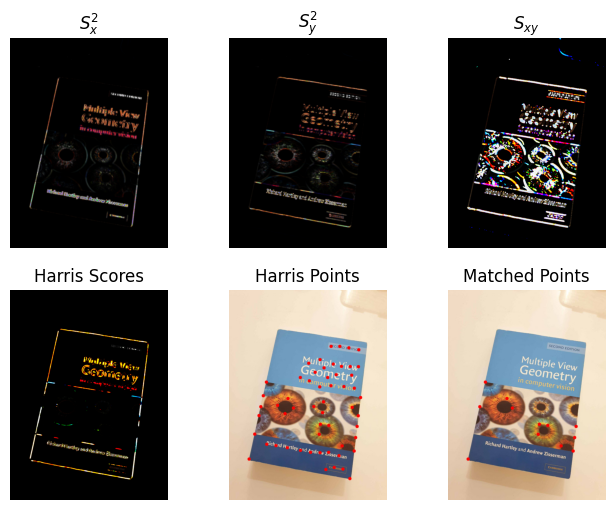

In [ ]:
matched_points_image_1, _, _, points_image_1, _, harris_scores_1, S1 = image_1_package
S2_x_1, S2_y_1, S_xy_1, _ = S1
plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 1)
show_image(S2_x_1)
plt.title('$S_x^2$')
plt.axis('off')
plt.subplot(2, 3, 2)
show_image(S2_y_1)
plt.title('$S_y^2$')
plt.axis('off')
plt.subplot(2, 3, 3)
show_image(S_xy_1)
plt.title('$S_{xy}$')
plt.axis('off')
plt.subplot(2, 3, 4)
show_image(harris_scores_1, 'res04_score')
plt.title('Harris Scores')
plt.axis('off')
plt.subplot(2, 3, 5)
show_image(points_image_1, 'res06_harris')
plt.title('Harris Points')
plt.axis('off')
plt.subplot(2, 3, 6)
show_image(matched_points_image_1, 'res08_corres')
plt.title('Matched Points')
plt.axis('off')
plt.show()

### Results of Image 2

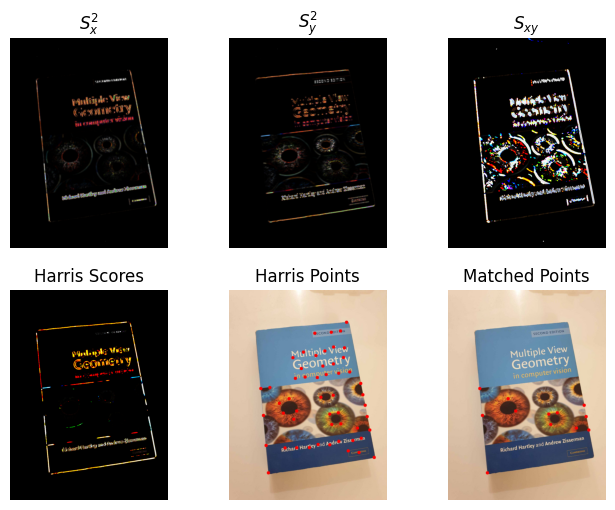

In [ ]:
matched_points_image_2, _, _, points_image_2, _, harris_scores_2, S2 = image_2_package
S2_x_2, S2_y_2, S_xy_2, _ = S2
plt.figure(figsize=(8, 6))
plt.subplot(2, 3, 1)
show_image(S2_x_2)
plt.title('$S_x^2$')
plt.axis('off')
plt.subplot(2, 3, 2)
show_image(S2_y_2)
plt.title('$S_y^2$')
plt.axis('off')
plt.subplot(2, 3, 3)
show_image(S_xy_2)
plt.title('$S_{xy}$')
plt.axis('off')
plt.subplot(2, 3, 4)
show_image(harris_scores_2, 'res05_score')
plt.title('Harris Scores')
plt.axis('off')
plt.subplot(2, 3, 5)
show_image(points_image_2, 'res07_harris')
plt.title('Harris Points')
plt.axis('off')
plt.subplot(2, 3, 6)
show_image(matched_points_image_2, 'res09_corres')
plt.title('Matched Points')
plt.axis('off')
plt.show()

### Final Result

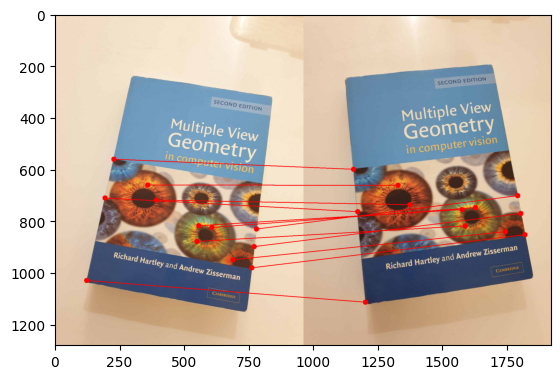

In [ ]:
show_image(result, 'res10')
plt.show()

## SIFT (Optional)

SIFT stands for Scale-Invariant Feature Transform, and it is a widely used algorithm in computer vision and image processing. SIFT was introduced by David Lowe in 1999 and has since become a standard tool for various applications, including object recognition, image stitching, and 3D reconstruction.

The SIFT algorithm is designed to detect and describe distinctive features in images that are invariant to changes in scale, rotation, and affine transformations. It operates by finding keypoints or interest points in an image that are likely to be unique and stable across different viewpoints.

The SIFT algorithm follows several key steps:

1. Scale-space extrema detection: The algorithm analyzes an image at multiple scales by applying a series of Gaussian blurs. It identifies potential interest points by detecting local maxima and minima in the difference-of-Gaussian images.

2. Keypoint localization: The algorithm refines the detected keypoints by eliminating poorly localized or unstable keypoints using a threshold on the local image contrast.

3. Orientation assignment: Each keypoint is assigned a dominant orientation based on local image gradients. This step ensures invariance to image rotation.

4. Keypoint descriptor generation: A descriptor is computed for each keypoint, which captures its local image information. The descriptor is based on the local image gradients and their orientations, creating a feature vector that represents the keypoint's characteristics.

5. Keypoint matching: SIFT descriptors from different images can be compared to find correspondences between keypoints. This matching step is crucial for tasks such as object recognition, image registration, or image stitching.

SIFT has been widely adopted due to its robustness against various image transformations and its ability to handle significant changes in viewpoint, lighting conditions, and partial occlusion. However, since its introduction, newer algorithms and techniques have been developed, such as Speeded-Up Robust Features (SURF) and features based on deep learning, which provide alternative or enhanced solutions to feature detection and description tasks.

In [328]:
def SIFT(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    return image_with_keypoints, keypoints, descriptors


def match_images_SIFT(image_1, image_2, match_threshold=0.75):
    image_with_keypoints_1, keypoints_1, descriptors_1 = SIFT(image_1)
    image_with_keypoints_2, keypoints_2, descriptors_2 = SIFT(image_2)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < match_threshold * n.distance:
            good_matches.append(m)

    matching_result = cv2.drawMatches(
        image_1,
        keypoints_1,
        image_2,
        keypoints_2,
        good_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    return matching_result, image_with_keypoints_1, image_with_keypoints_2


image_1 = load_image('Q3_1.jpg', False)
image_2 = load_image('Q3_2.jpg', False)

matching_result, image_keypoints_1, image_keypoints_2 = match_images_SIFT(image_1, image_2)

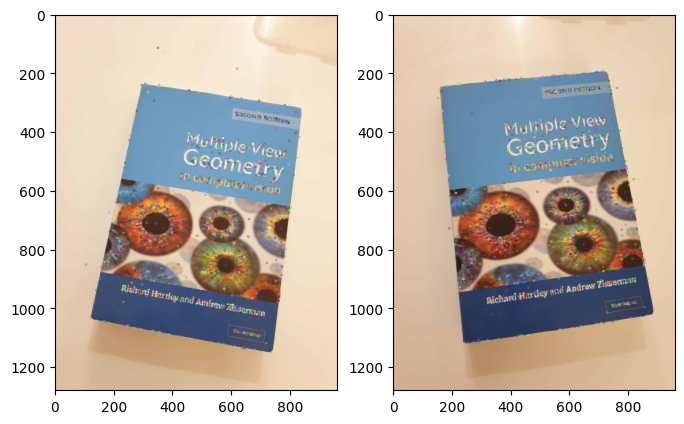

In [329]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
show_image(image_keypoints_1, 'res_sift_image_1')
plt.subplot(1, 2, 2)
show_image(image_keypoints_2, 'res_sift_image_2')

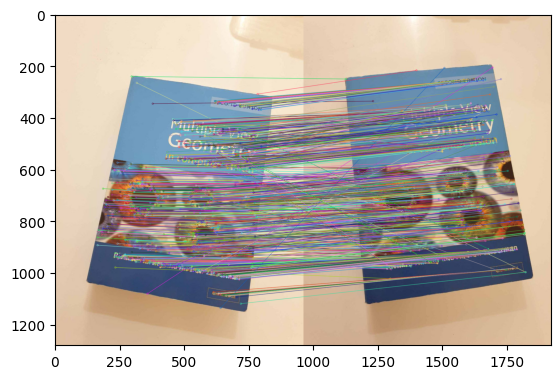

In [330]:
show_image(matching_result, 'res_sift_matched_images')

## RANSAC - removing outliers (Optional)

448.0 from 986 lines were removed.


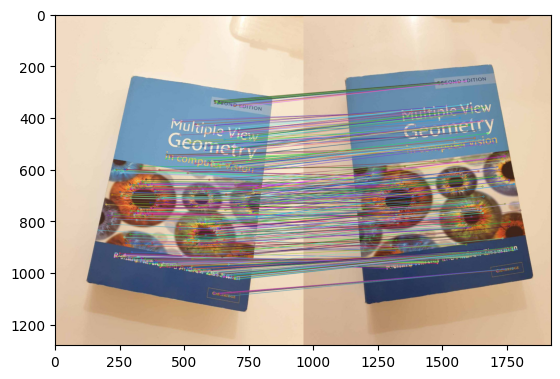

In [332]:
def match_images_SIFT_RANSAC(image_1, image_2, match_threshold=0.75, RANSIC_threshold=0.5):
    image_with_keypoints_1, keypoints_1, descriptors_1 = SIFT(image_1)
    image_with_keypoints_2, keypoints_2, descriptors_2 = SIFT(image_2)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < match_threshold * n.distance:
            good_matches.append(m)

    src_points = np.float32([keypoints_1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_points = np.float32([keypoints_2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    homography, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, RANSIC_threshold)
    print(f'{mask.shape[0] - mask[:, 0].sum()} from {mask.shape[0]} lines were removed.')
    inlier_matches = [m for i, m in enumerate(good_matches) if mask[i][0]]

    matching_result = cv2.drawMatches(
        image_1,
        keypoints_1,
        image_2,
        keypoints_2,
        inlier_matches,
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    return matching_result, image_with_keypoints_1, image_with_keypoints_2

'''
    Change RANSIC_threshold to obtain an appropriate result
'''
matching_result, image_keypoints_1, image_keypoints_2 = match_images_SIFT_RANSAC(
    image_1,
    image_2,
    match_threshold=0.75,
    RANSIC_threshold=0.5
)
show_image(matching_result, 'res_ransic')